https://gist.github.com/simoninithomas/d6adc6edb0a7f37d6323a5e3d2ab72ec

## Step 1: Import the libraries 📚

In [1]:
import tensorflow.compat.v1 as tf      # Deep Learning library
import numpy as np           # Handle matrices
from vizdoom import *        # Doom Environment
from tensorflow.python.framework import ops
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense



import random                # Handling random number generation
import time                  # Handling time calculation
from skimage import transform# Help us to preprocess the frames

from collections import deque# Ordered collection with ends
import matplotlib.pyplot as plt # Display graphs

import warnings # This ignore all the warning messages that are normally printed during the training because of skiimage
warnings.filterwarnings('ignore')

## Step 2: Create our environment 🎮
- Now that we imported the libraries/dependencies, we will create our environment.
- Doom environment takes:
    - A `configuration file` that **handle all the options** (size of the frame, possible actions...)
    - A `scenario file`: that **generates the correct scenario** (in our case basic **but you're invited to try other scenarios**).
- Note: We have 3 possible actions: turn left, turn right, shoot (attack)... so we don't need to do one hot encoding (thanks to <a href="https://stackoverflow.com/users/2237916/silgon">silgon</a> for figuring out). 

<br>
REWARDS:

- death penalty = 100

In [2]:
"""
Here we create our environment
"""
def create_environment():
    game = DoomGame()

    # Load the correct configuration
    game.load_config('VizDoom/scenarios/defend_the_center.cfg')

    # Load the correct scenario (in our case defend_the_center)
    game.set_doom_scenario_path('VizDoom/scenarios/defend_the_center.wad')

    game.set_window_visible(False) #no pop out window
    game.init()

    # Here we create an hot encoded version of our actions (3 possible actions)
    possible_actions = np.identity(3,dtype=int).tolist()

    return game, possible_actions

In [3]:
import os
current_directory = os.getcwd()
files_and_directories = os.listdir(current_directory)

In [4]:
game, possible_actions = create_environment()

## Step 3: Define the preprocessing functions ⚙️
### preprocess_frame
Preprocessing is an important step, <b>because we want to reduce the complexity of our states to reduce the computation time needed for training.</b>
<br><br>
Our steps:
- Grayscale each of our frames (because <b> color does not add important information </b>). But this is already done by the config file.
- Crop the screen (in our case we remove the roof because it contains no information)
- We normalize pixel values
- Finally we resize the preprocessed frame

In [5]:
"""
    preprocess_frame:
    Take a frame.
    Resize it.
        __________________
        |                 |
        |                 |
        |                 |
        |                 |
        |_________________|

        to
        _____________
        |            |
        |            |
        |            |
        |____________|
    Normalize it.

    return preprocessed_frame

    """
def preprocess_frame(frame):
    # Crop the screen (remove part that contains no information)
    # [Up: Down, Left: right]
    cropped_frame = frame[15:-5, 20:-20]

    # Check if the cropped frame has non-zero dimensions
    if cropped_frame.size == 0:
        # If the cropped frame has zero dimensions, return a default frame with zeros
        return np.zeros((100, 120), dtype=np.float32)

    # Normalize Pixel Values
    normalized_frame = cropped_frame / 255.0

    # Resize
    preprocessed_frame = transform.resize(cropped_frame, [100, 120])

    return preprocessed_frame # 100x120x1 frame

### stack_frames
👏 This part was made possible thanks to help of <a href="https://github.com/Miffyli">Anssi</a><br>

As explained in this really <a href="https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/">  good article </a> we stack frames.

Stacking frames is really important because it helps us to **give have a sense of motion to our Neural Network.**

- First we preprocess frame
- Then we append the frame to the deque that automatically **removes the oldest frame**
- Finally we **build the stacked state**

This is how work stack:
- For the first frame, we feed 4 frames
- At each timestep, **we add the new frame to deque and then we stack them to form a new stacked frame**
- And so on
<img src="https://raw.githubusercontent.com/simoninithomas/Deep_reinforcement_learning_Course/master/DQN/Space%20Invaders/assets/stack_frames.png" alt="stack">
- If we're done, **we create a new stack with 4 new frames (because we are in a new episode)**.

In [6]:
stack_size = 4 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros((100,120), dtype=int) for i in range(stack_size)], maxlen=4)

def stack_frames(stacked_frames, state, is_new_episode):
    if state.size == 0:
        # Return the existing stacked frames without modification
        return np.stack(stacked_frames, axis=2), stacked_frames

    # Preprocess frame
    frame = preprocess_frame(state)

    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((100,120), dtype=int) for i in range(stack_size)], maxlen=4)

        # Because we're in a new episode, copy the same frame 4x
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)
        stacked_frames.append(frame)

        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)

    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2)

    return stacked_state, stacked_frames

## Step 4: Set up our hyperparameters ⚗️
In this part we'll set up our different hyperparameters. But when you implement a Neural Network by yourself you will **not implement hyperparamaters at once but progressively**.

- First, you begin by defining the neural networks hyperparameters when you implement the model.
- Then, you'll add the training hyperparameters when you implement the training algorithm.

In [7]:
### MODEL HYPERPARAMETERS
state_size = [100,120,4]      # Our input is a stack of 4 frames hence 100x120x4 (Width, height, channels)
action_size = game.get_available_buttons_size()              # 3 possible actions
learning_rate =  0.00025      # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 1500         # Total episodes for training
max_steps = 10000              # Max possible steps in an episode
batch_size = 64

# FIXED Q TARGETS HYPERPARAMETERS
max_tau = 10000 #Tau is the C step where we update our target network

# EXPLORATION HYPERPARAMETERS for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability
decay_rate = 0.00005            # exponential decay rate for exploration prob

# Q LEARNING hyperparameters
gamma = 0.95               # Discounting rate

### MEMORY HYPERPARAMETERS
## If you have GPU change to 1million
pretrain_length = 10             # Number of experiences stored in the Memory when initialized for the first time
memory_size = 10 ##100000                 # Number of experiences the Memory can keep

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = False

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

## Step 5: Create our Dueling Double Deep Q-learning Neural Network model (aka DDDQN) 🧠
<img src="https://cdn-images-1.medium.com/max/1500/1*FkHqwA2eSGixdS-3dvVoMA.png" alt="Dueling Double Deep Q Learning Model" />
This is our Dueling Double Deep Q-learning model:
- We take a stack of 4 frames as input
- It passes through 3 convnets
- Then it is flatened
- Then it is passed through 2 streams
    - One that calculates V(s)
    - The other that calculates A(s,a)
- Finally an agregating layer
- It outputs a Q value for each actions

In [8]:
tf.disable_eager_execution()

In [9]:
class DDDQNNet:
    def __init__(self, state_size, action_size, learning_rate, name):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.name = name
        random_var = 64
        
        
        # We use tf.variable_scope here to know which network we're using (DQN or target_net)
        # it will be useful when we will update our w- parameters (by copy the DQN parameters)
        with tf.compat.v1.variable_scope(self.name):
            
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 100, 120, 4]
            self.inputs_ = tf.compat.v1.placeholder(tf.float32, [None, *state_size], name="inputs")
            
            #
            self.ISWeights_ = tf.compat.v1.placeholder(tf.float32, [None,1], name='IS_weights')
            
            self.actions_ = tf.placeholder(tf.float32, [random_var, action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.compat.v1.placeholder(tf.float32, [None], name="target")
            
            """
            First convnet:
            CNN
            ELU
            """
            # Input is 100x120x4
            self.conv1 = Conv2D(
                    filters=32,
                    kernel_size=[8, 8],
                    strides=[4, 4],
                    padding="VALID",
                    kernel_initializer=tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"),
                    name="conv1")(self.inputs_)
            
            self.conv1_out = tf.nn.elu(self.conv1, name="conv1_out")
            
            
            """
            Second convnet:
            CNN
            ELU
            """
            self.conv2 = Conv2D(
                                 filters = 64,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"),
                                 name = "conv2")(self.conv1_out)

            self.conv2_out = tf.nn.elu(self.conv2, name="conv2_out")
            
            
            """
            Third convnet:
            CNN
            ELU
            """
            self.conv3 = Conv2D(
                                 filters = 128,
                                 kernel_size = [4,4],
                                 strides = [2,2],
                                 padding = "VALID",
                                kernel_initializer=tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"),
                                 name = "conv3")(self.conv2_out)

            self.conv3_out = tf.nn.elu(self.conv3, name="conv3_out")
            
            
            self.flatten = Flatten(data_format='channels_last')(self.conv3)
            
            
            ## Here we separate into two streams
            # The one that calculate V(s)
            self.value_fc = Dense(
                                  units = 512,
                                  activation = tf.nn.elu,
                                       kernel_initializer=tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"),
                                name="value_fc")(self.flatten)
            
            self.value = Dense(
                                        units = 1,
                                        activation = None,
                                        kernel_initializer=tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"),
                                name="value")(self.value_fc)
            
            # The one that calculate A(s,a)
            self.advantage_fc = Dense(
                                  units = 512,
                                  activation = tf.nn.elu,
                                       kernel_initializer=tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"),
                                name="advantage_fc")(self.flatten)
            
            self.advantage = Dense(
                                        units = self.action_size,
                                        activation = None,
                                        kernel_initializer=tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform"),
                                name="advantages")(self.advantage_fc)
            
            # Agregating layer
            # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
            self.output = self.value + tf.subtract(self.advantage, tf.reduce_mean(self.advantage, axis=1, keepdims=True))
              
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_), axis=1)
            
            # The loss is modified because of PER 
            self.absolute_errors = tf.abs(self.target_Q - self.Q)# for updating Sumtree
            
            self.loss = tf.reduce_mean(self.ISWeights_ * tf.math.squared_difference(self.target_Q, self.Q))
            
            self.optimizer = tf.compat.v1.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)

In [10]:
# Reset the graph
ops.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DDDQNNet(state_size, action_size, learning_rate, name="DQNetwork")

# Instantiate the target network
TargetNetwork = DDDQNNet(state_size, action_size, learning_rate, name="TargetNetwork")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


## Step 6: Prioritized Experience Replay 🔁
Now that we create our Neural Network, **we need to implement the Prioritized Experience Replay method.** <br>

As explained in the article, **we can't use a simple array to do that because sampling from it will be not efficient, so we use a binary tree data type (in a binary tree each node has no + than 2 children).** More precisely, a sumtree, which is a binary tree where parents nodes are the sum of the children nodes.

If you don't know what is a binary tree check this awesome video https://www.youtube.com/watch?v=oSWTXtMglKE


This SumTree implementation was taken from Morvan Zhou in his chinese course about Reinforcement Learning

To summarize:
- **Step 1**: We construct a SumTree, which is a Binary Sum tree where leaves contains the priorities and a data array where index points to the index of leaves.
    <img src="https://cdn-images-1.medium.com/max/1200/1*Go9DNr7YY-wMGdIQ7HQduQ.png" alt="SumTree"/>
    <br><br>
    - **def __init__**: Initialize our SumTree data object with all nodes = 0 and data (data array) with all = 0.
    - **def add**: add our priority score in the sumtree leaf and experience (S, A, R, S', Done) in data.
    - **def update**: we update the leaf priority score and propagate through tree.
    - **def get_leaf**: retrieve priority score, index and experience associated with a leaf.
    - **def total_priority**: get the root node value to calculate the total priority score of our replay buffer.
<br><br>
- **Step 2**: We create a Memory object that will contain our sumtree and data.
    - **def __init__**: generates our sumtree and data by instantiating the SumTree object.
    - **def store**: we store a new experience in our tree. Each new experience will **have priority = max_priority** (and then this priority will be corrected during the training (when we'll calculating the TD error hence the priority score).
    - **def sample**:
         - First, to sample a minibatch of k size, the range [0, priority_total] is / into k ranges.
         - Then a value is uniformly sampled from each range
         - We search in the sumtree, the experience where priority score correspond to sample values are retrieved from.
         - Then, we calculate IS weights for each minibatch element
    - **def update_batch**: update the priorities on the tree

In [11]:
class SumTree(object):
    """
    This SumTree code is modified version of Morvan Zhou:
    https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/blob/master/contents/5.2_Prioritized_Replay_DQN/RL_brain.py
    """
    data_pointer = 0

    """
    Here we initialize the tree with all nodes = 0, and initialize the data with all values = 0
    """
    def __init__(self, capacity):
        self.capacity = capacity # Number of leaf nodes (final nodes) that contains experiences

        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema above
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)

        """ tree:
            0
           / \
          0   0
         / \ / \
        0  0 0  0  [Size: capacity] it's at this line that there is the priorities score (aka pi)
        """

        # Contains the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)


    """
    Here we add our priority score in the sumtree leaf and add the experience in data
    """
    def add(self, priority, data):
        # Look at what index we want to put the experience
        tree_index = self.data_pointer + self.capacity - 1

        """ tree:
            0
           / \
          0   0
         / \ / \
tree_index  0 0  0  We fill the leaves from left to right
        """

        # Update data frame
        self.data[self.data_pointer] = data

        # Update the leaf
        self.update (tree_index, priority)

        # Add 1 to data_pointer
        self.data_pointer += 1

        if self.data_pointer >= self.capacity:  # If we're above the capacity, you go back to first index (we overwrite)
            self.data_pointer = 0


    """
    Update the leaf priority score and propagate the change through tree
    """
    def update(self, tree_index, priority):
        # Change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority

        # then propagate the change through tree
        while tree_index != 0:    # this method is faster than the recursive loop in the reference code

            """
            Here we want to access the line above
            THE NUMBERS IN THIS TREE ARE THE INDEXES NOT THE PRIORITY VALUES

                0
               / \
              1   2
             / \ / \
            3  4 5  [6]

            If we are in leaf at index 6, we updated the priority score
            We need then to update index 2 node
            So tree_index = (tree_index - 1) // 2
            tree_index = (6-1)//2
            tree_index = 2 (because // round the result)
            """
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change


    """
    Here we get the leaf_index, priority value of that leaf and experience associated with that index
    """
    def get_leaf(self, v):
        """
        Tree structure and array storage:
        Tree index:
             0         -> storing priority sum
            / \
          1     2
         / \   / \
        3   4 5   6    -> storing priority for experiences
        Array type for storing:
        [0,1,2,3,4,5,6]
        """
        parent_index = 0

        while True: # the while loop is faster than the method in the reference code
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1

            # If we reach bottom, end the search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break

            else: # downward search, always search for a higher priority node

                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index

                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index

        data_index = leaf_index - self.capacity + 1

        return leaf_index, self.tree[leaf_index], self.data[data_index]

    @property
    def total_priority(self):
        return self.tree[0] # Returns the root node

Here we don't use deque anymore

In [12]:
class Memory(object):  # stored as ( s, a, r, s_ ) in SumTree
    """
    This SumTree code is modified version and the original code is from:
    https://github.com/jaara/AI-blog/blob/master/Seaquest-DDQN-PER.py
    """
    PER_e = 0.01  # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
    PER_a = 0.6  # Hyperparameter that we use to make a tradeoff between taking only exp with high priority and sampling randomly
    PER_b = 0.4  # importance-sampling, from initial value increasing to 1

    PER_b_increment_per_sampling = 0.001

    absolute_error_upper = 1.  # clipped abs error

    def __init__(self, capacity):
        # Making the tree
        """
        Remember that our tree is composed of a sum tree that contains the priority scores at his leaf
        And also a data array
        We don't use deque because it means that at each timestep our experiences change index by one.
        We prefer to use a simple array and to overwrite when the memory is full.
        """
        self.tree = SumTree(capacity)

    """
    Store a new experience in our tree
    Each new experience have a score of max_prority (it will be then improved when we use this exp to train our DDQN)
    """
    def store(self, experience):
        # Find the max priority
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])

        # If the max priority = 0 we can't put priority = 0 since this exp will never have a chance to be selected
        # So we use a minimum priority
        if max_priority == 0:
            max_priority = self.absolute_error_upper

        self.tree.add(max_priority, experience)   # set the max p for new p


    """
    - First, to sample a minibatch of k size, the range [0, priority_total] is / into k ranges.
    - Then a value is uniformly sampled from each range
    - We search in the sumtree, the experience where priority score correspond to sample values are retrieved from.
    - Then, we calculate IS weights for each minibatch element
    """
    def sample(self, n):
        # Create a sample array that will contains the minibatch
        memory_b = []

        b_idx, b_ISWeights = np.empty((n,), dtype=np.int32), np.empty((n, 1), dtype=np.float32)

        # Calculate the priority segment
        # Here, as explained in the paper, we divide the Range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority / n       # priority segment

        # Here we increasing the PER_b each time we sample a new minibatch
        self.PER_b = np.min([1., self.PER_b + self.PER_b_increment_per_sampling])  # max = 1

        # Calculating the max_weight
        p_min = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_priority
        max_weight = (p_min * n) ** (-self.PER_b)

        for i in range(n):
            """
            A value is uniformly sample from each range
            """
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)

            """
            Experience that correspond to each value is retrieved
            """
            index, priority, data = self.tree.get_leaf(value)

            #P(j)
            sampling_probabilities = priority / self.tree.total_priority

            #  IS = (1/N * 1/P(i))**b /max wi == (N*P(i))**-b  /max wi
            b_ISWeights[i, 0] = np.power(n * sampling_probabilities, -self.PER_b)/ max_weight

            b_idx[i]= index

            experience = [data]

            memory_b.append(experience)

        return b_idx, memory_b, b_ISWeights

    """
    Update the priorities on the tree
    """
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.PER_a)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)

Here we'll **deal with the empty memory problem**: we pre-populate our memory by taking random actions and storing the experience.

In [13]:
# Instantiate memory
memory = Memory(memory_size)

# Render the environment
game.new_episode()

for i in range(pretrain_length):
    # If it's the first step
    if i == 0:
        # First we need a state
        state = game.get_state().screen_buffer
        state, stacked_frames = stack_frames(stacked_frames, state, True)

    # Random action
    action = random.choice(possible_actions)

    # Get the rewards
    reward = game.make_action(action)

    # Look if the episode is finished
    done = game.is_episode_finished()

    # If we're dead
    if done:
        # We finished the episode
        next_state = np.zeros(state.shape)

        # Add experience to memory
        #experience = np.hstack((state, [action, reward], next_state, done))

        experience = state, action, reward, next_state, done
        memory.store(experience)

        # Start a new episode
        game.new_episode()

        # First we need a state
        state = game.get_state().screen_buffer

        # Stack the frames
        state, stacked_frames = stack_frames(stacked_frames, state, True)

    else:
        # Get the next state
        next_state = game.get_state().screen_buffer
        next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

        # Add experience to memory
        experience = state, action, reward, next_state, done
        memory.store(experience)

        # Our state is now the next_state
        state = next_state

## Step 7: Set up Tensorboard 📊
For more information about tensorboard, please watch this <a href="https://www.youtube.com/embed/eBbEDRsCmv4">excellent 30min tutorial</a> <br><br>
To launch tensorboard : `tensorboard --logdir=/tensorboard/dddqn/1`

In [14]:
# Setup TensorBoard Writer
writer = tf.summary.FileWriter("./tensorboard/dddqn/1")

## Losses
tf.summary.scalar("Loss", DQNetwork.loss)

write_op = tf.summary.merge_all()

## Step 8: Train our Agent 🏃‍♂️

Our algorithm:
<br>
* Initialize the weights for DQN
* Initialize target value weights w- <- w
* Init the environment
* Initialize the decay rate (that will use to reduce epsilon) 
<br><br>
* **For** episode to max_episode **do** 
    * Make new episode
    * Set step to 0
    * Observe the first state $s_0$
    <br><br>
    * **While** step < max_steps **do**:
        * Increase decay_rate
        * With $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
        * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
        * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
        
        * Sample random mini-batch from $D$: $<s, a, r, s'>$
        * Set target $\hat{Q} = r$ if the episode ends at $+1$, otherwise set $\hat{Q} = r + \gamma Q(s',argmax_{a'}{Q(s', a', w), w^-)}$
        * Make a gradient descent step with loss $(\hat{Q} - Q(s, a))^2$
        * Every C steps, reset: $w^- \leftarrow w$
    * **endfor**
    <br><br>
* **endfor**

    

In [15]:
"""
This function will do the part
With ϵ select a random action atat, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)

    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        action = random.choice(possible_actions)

    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})

        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[int(choice)]

    return action, explore_probability

In [16]:
# This function helps us to copy one set of variables to another
# In our case we use it when we want to copy the parameters of DQN to Target_network
# Thanks of the very good implementation of Arthur Juliani https://github.com/awjuliani
def update_target_graph():

    # Get the parameters of our DQNNetwork
    from_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, "DQNetwork")

    # Get the parameters of our Target_network
    to_vars = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, "TargetNetwork")

    op_holder = []

    # Update our target_network parameters with DQNNetwork parameters
    for from_var,to_var in zip(from_vars,to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder

In [17]:
training = True

Episode: 0 Step: 330 Total reward: -1.0 Training loss: 0.0000 Explore P: 0.9838
Model Saved


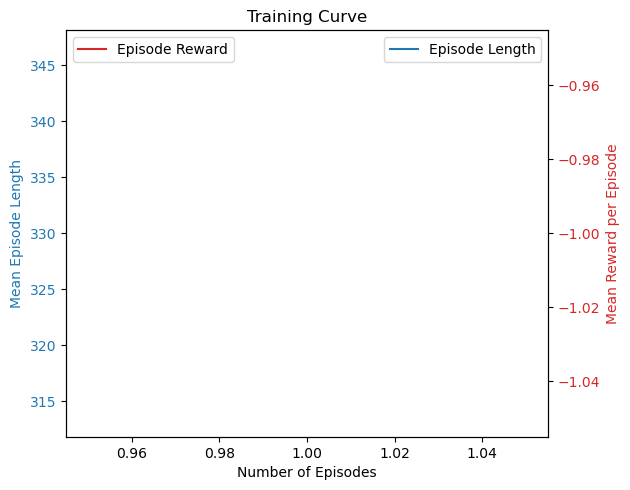

Episode: 1 Step: 270 Total reward: 2.0 Training loss: 0.0000 Explore P: 0.9707
Episode: 2 Step: 276 Total reward: 0.0 Training loss: 0.0000 Explore P: 0.9576
Episode: 3 Step: 222 Total reward: -1.0 Training loss: 0.0000 Explore P: 0.9471
Episode: 4 Step: 314 Total reward: 0.0 Training loss: 0.0000 Explore P: 0.9325
Episode: 5 Step: 254 Total reward: -1.0 Training loss: 0.0000 Explore P: 0.9209
Model Saved


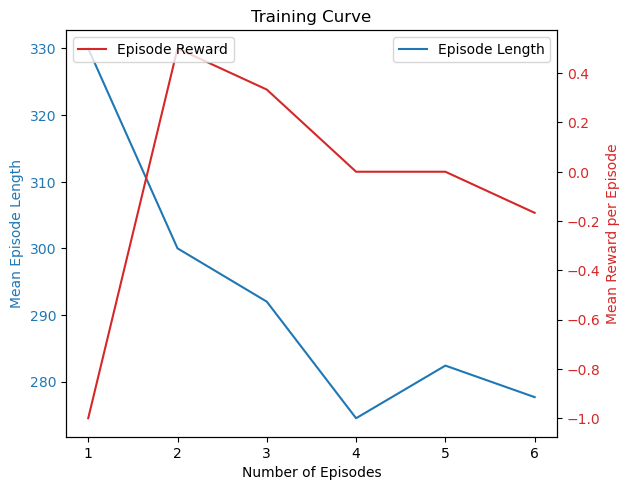

Episode: 6 Step: 282 Total reward: -1.0 Training loss: 0.0000 Explore P: 0.9081
Episode: 7 Step: 284 Total reward: 0.0 Training loss: 0.0000 Explore P: 0.8955
Episode: 8 Step: 304 Total reward: 0.0 Training loss: 0.0000 Explore P: 0.8821
Episode: 9 Step: 264 Total reward: -1.0 Training loss: 0.0000 Explore P: 0.8707
Episode: 10 Step: 330 Total reward: 0.0 Training loss: 0.0000 Explore P: 0.8566
Model Saved


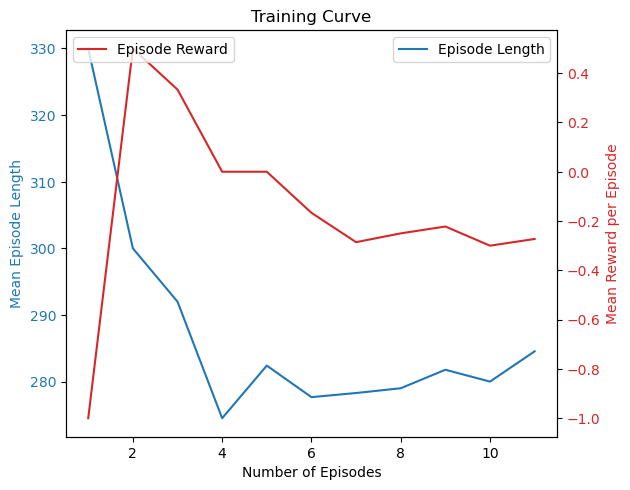

Episode: 11 Step: 328 Total reward: -1.0 Training loss: 0.0000 Explore P: 0.8428


In [22]:
# Saver will help us to save our model
saver = tf.train.Saver()
avg_episode_lengths = 0
avg_episode_rewards = 0
episode_lengths = []
eepisode_rewards = []
if training == True:
    with tf.Session() as sess:
        # Initialize the variables
        sess.run(tf.global_variables_initializer())
        
        # Initialize the decay rate (that will use to reduce epsilon) 
        decay_step = 0
        
        # Set tau = 0
        tau = 0

        # Init the game
        game.init()
        
        # Update the parameters of our TargetNetwork with DQN_weights
        update_target = update_target_graph()
        sess.run(update_target)
        
        for episode in range(total_episodes):
            # Set step to 0
            step = 0
            
            # Initialize the rewards of the episode
            episode_rewards = []
            
            # Make a new episode and observe the first state
            game.new_episode()
            
            state = game.get_state().screen_buffer
            
            # Remember that stack frame function also call our preprocess function.
            state, stacked_frames = stack_frames(stacked_frames, state, True)
        
            while step < max_steps:
                step += 1
                
                # Increase the C step
                tau += 1
                
                # Increase decay_step
                decay_step +=1
                
                # With ϵ select a random action atat, otherwise select a = argmaxQ(st,a)
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)

                # Do the action
                reward = game.make_action(action)

                # Look if the episode is finished
                done = game.is_episode_finished()
                
                # Add the reward to total reward
                episode_rewards.append(reward)

                # If the game is finished
                if done:
                    # the episode ends so no next state
                    next_state = np.zeros((120,140), dtype=int)
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                    savestep = step

                    # Set step = max_steps to end the episode
                    step = max_steps

                    # Get the total reward of the episode
                    total_reward = np.sum(episode_rewards)

                    print('Episode: {}'.format(episode), 'Step: {}'.format(savestep),
                              'Total reward: {}'.format(total_reward),
                              'Training loss: {:.4f}'.format(loss),
                              'Explore P: {:.4f}'.format(explore_probability))
                    
                    episode_lengths.append(savestep)
                    eepisode_rewards.append(total_reward)
                    # Add experience to memory
                    experience = state, action, reward, next_state, done
                    memory.store(experience)

                else:
                    # Get the next state
                    next_state = game.get_state().screen_buffer
                    
                    # Stack the frame of the next_state
                    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                    

                    # Add experience to memory
                    experience = state, action, reward, next_state, done
                    memory.store(experience)
                    
                    # st+1 is now our current state
                    state = next_state


                ### LEARNING PART            
                # Obtain random mini-batch from memory
                tree_idx, batch, ISWeights_mb = memory.sample(batch_size)
                
                states_mb = np.array([each[0][0] for each in batch], ndmin=3)
                actions_mb = np.array([each[0][1] for each in batch])
                rewards_mb = np.array([each[0][2] for each in batch]) 
                next_states_mb = np.array([each[0][3] for each in batch], ndmin=3)
                dones_mb = np.array([each[0][4] for each in batch])

                target_Qs_batch = []

                
                ### DOUBLE DQN Logic
                # Use DQNNetwork to select the action to take at next_state (a') (action with the highest Q-value)
                # Use TargetNetwork to calculate the Q_val of Q(s',a')
                
                # Get Q values for next_state 
                q_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})
                
                # Calculate Qtarget for all actions that state
                q_target_next_state = sess.run(TargetNetwork.output, feed_dict = {TargetNetwork.inputs_: next_states_mb})
                
                
                # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma * Qtarget(s',a') 
                for i in range(0, len(batch)):
                    terminal = dones_mb[i]
                    
                    # We got a'
                    action = np.argmax(q_next_state[i])

                    # If we are in a terminal state, only equals reward
                    if terminal:
                        target_Qs_batch.append(rewards_mb[i])
                        
                    else:
                        # Take the Qtarget for action a'
                        target = rewards_mb[i] + gamma * q_target_next_state[i][action]
                        target_Qs_batch.append(target)
                        

                targets_mb = np.array([each for each in target_Qs_batch])

                
                _, loss, absolute_errors = sess.run([DQNetwork.optimizer, DQNetwork.loss, DQNetwork.absolute_errors],
                                    feed_dict={DQNetwork.inputs_: states_mb,
                                               DQNetwork.target_Q: targets_mb,
                                               DQNetwork.actions_: actions_mb,
                                              DQNetwork.ISWeights_: ISWeights_mb})
              
                
                
                # Update priority
                memory.batch_update(tree_idx, absolute_errors)
                
                
                # Write TF Summaries
                summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                   DQNetwork.target_Q: targets_mb,
                                                   DQNetwork.actions_: actions_mb,
                                              DQNetwork.ISWeights_: ISWeights_mb})
                writer.add_summary(summary, episode)
                writer.flush()
                
                if tau > max_tau:
                    # Update the parameters of our TargetNetwork with DQN_weights
                    update_target = update_target_graph()
                    sess.run(update_target)
                    tau = 0
                    print("Model updated")

            # Save model every 5 episodes
            if episode % 5 == 0:
                avg_episode_lengths = [np.mean(episode_lengths[:i + 1]) for i in range(episode + 1)]
                avg_episode_rewards = [np.mean(eepisode_rewards[:i + 1]) for i in range(episode + 1)]
                save_path = saver.save(sess, "./models/model.ckpt")
                print("Model Saved")

                # Clear previous output
                clear_output(wait=True)
                
                # Plotting
                fig, ax1 = plt.subplots()

                ax1.set_xlabel('Number of Episodes')
                ax1.set_ylabel('Mean Episode Length', color='tab:blue')
                ax1.plot(range(1, episode + 2), avg_episode_lengths, color='tab:blue',label='Episode Length')
                ax1.tick_params(axis='y', labelcolor='tab:blue')

                ax2 = ax1.twinx()
                ax2.set_ylabel('Mean Reward per Episode', color='tab:red')
                ax2.plot(range(1, episode + 2), avg_episode_rewards, color='tab:red',label='Episode Reward')
                ax2.tick_params(axis='y', labelcolor='tab:red')

                fig.tight_layout()
                ax1.legend(loc='upper right')
                ax2.legend(loc='upper left')
                plt.title('Training Curve')

                plt.show()

## Step 9: Watch our Agent play 👀
Now that we trained our agent, we can test it

In [ ]:
with tf.Session() as sess:
    
    game = DoomGame()
    
    # Load the correct configuration (TESTING)
    game.load_config('VizDoom/scenarios/defend_the_center.cfg')
    
    # Load the correct scenario (in our case deadly_corridor scenario)
    game.set_doom_scenario_path('VizDoom/scenarios/defend_the_center.wad')
    
    game.init()    
    
    # Load the model
    saver.restore(sess, "./models/model.ckpt")
    game.init()
    
    for i in range(10):
        
        game.new_episode()
        state = game.get_state().screen_buffer
        state, stacked_frames = stack_frames(stacked_frames, state, True)
    
        while not game.is_episode_finished():
            ## EPSILON GREEDY STRATEGY
            # Choose action a from state s using epsilon greedy.
            ## First we randomize a number
            exp_exp_tradeoff = np.random.rand()
            

            explore_probability = 0.01
    
            if (explore_probability > exp_exp_tradeoff):
                # Make a random action (exploration)
                action = random.choice(possible_actions)
        
            else:
                # Get action from Q-network (exploitation)
                # Estimate the Qs values state
                Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
        
                # Take the biggest Q value (= the best action)
                choice = np.argmax(Qs)
                action = possible_actions[int(choice)]
            
            game.make_action(action)
            done = game.is_episode_finished()
        
            if done:
                break  
                
            else:
                next_state = game.get_state().screen_buffer
                next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
                state = next_state
        
        score = game.get_total_reward()
        print("Score: ", score)
    
    game.close()

INFO:tensorflow:Restoring parameters from ./models/model.ckpt
Score:  0.0
Score:  0.0
Score:  2.0
Score:  1.0
Score:  1.0
Score:  1.0
Score:  0.0
Score:  0.0
Score:  0.0
Score:  1.0
